In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import utilsClust
from sklearn.metrics import silhouette_score

# Dataset loading and visualisation

In [19]:
df = pd.read_csv("../data/RNAseqData.csv", index_col = 0)
df.shape

(200, 14809)

In [20]:
X = df.transpose()

In [14]:
#!python -m pip install ChernoffFace

In [15]:
from ChernoffFace import *
import numpy
import matplotlib.cm

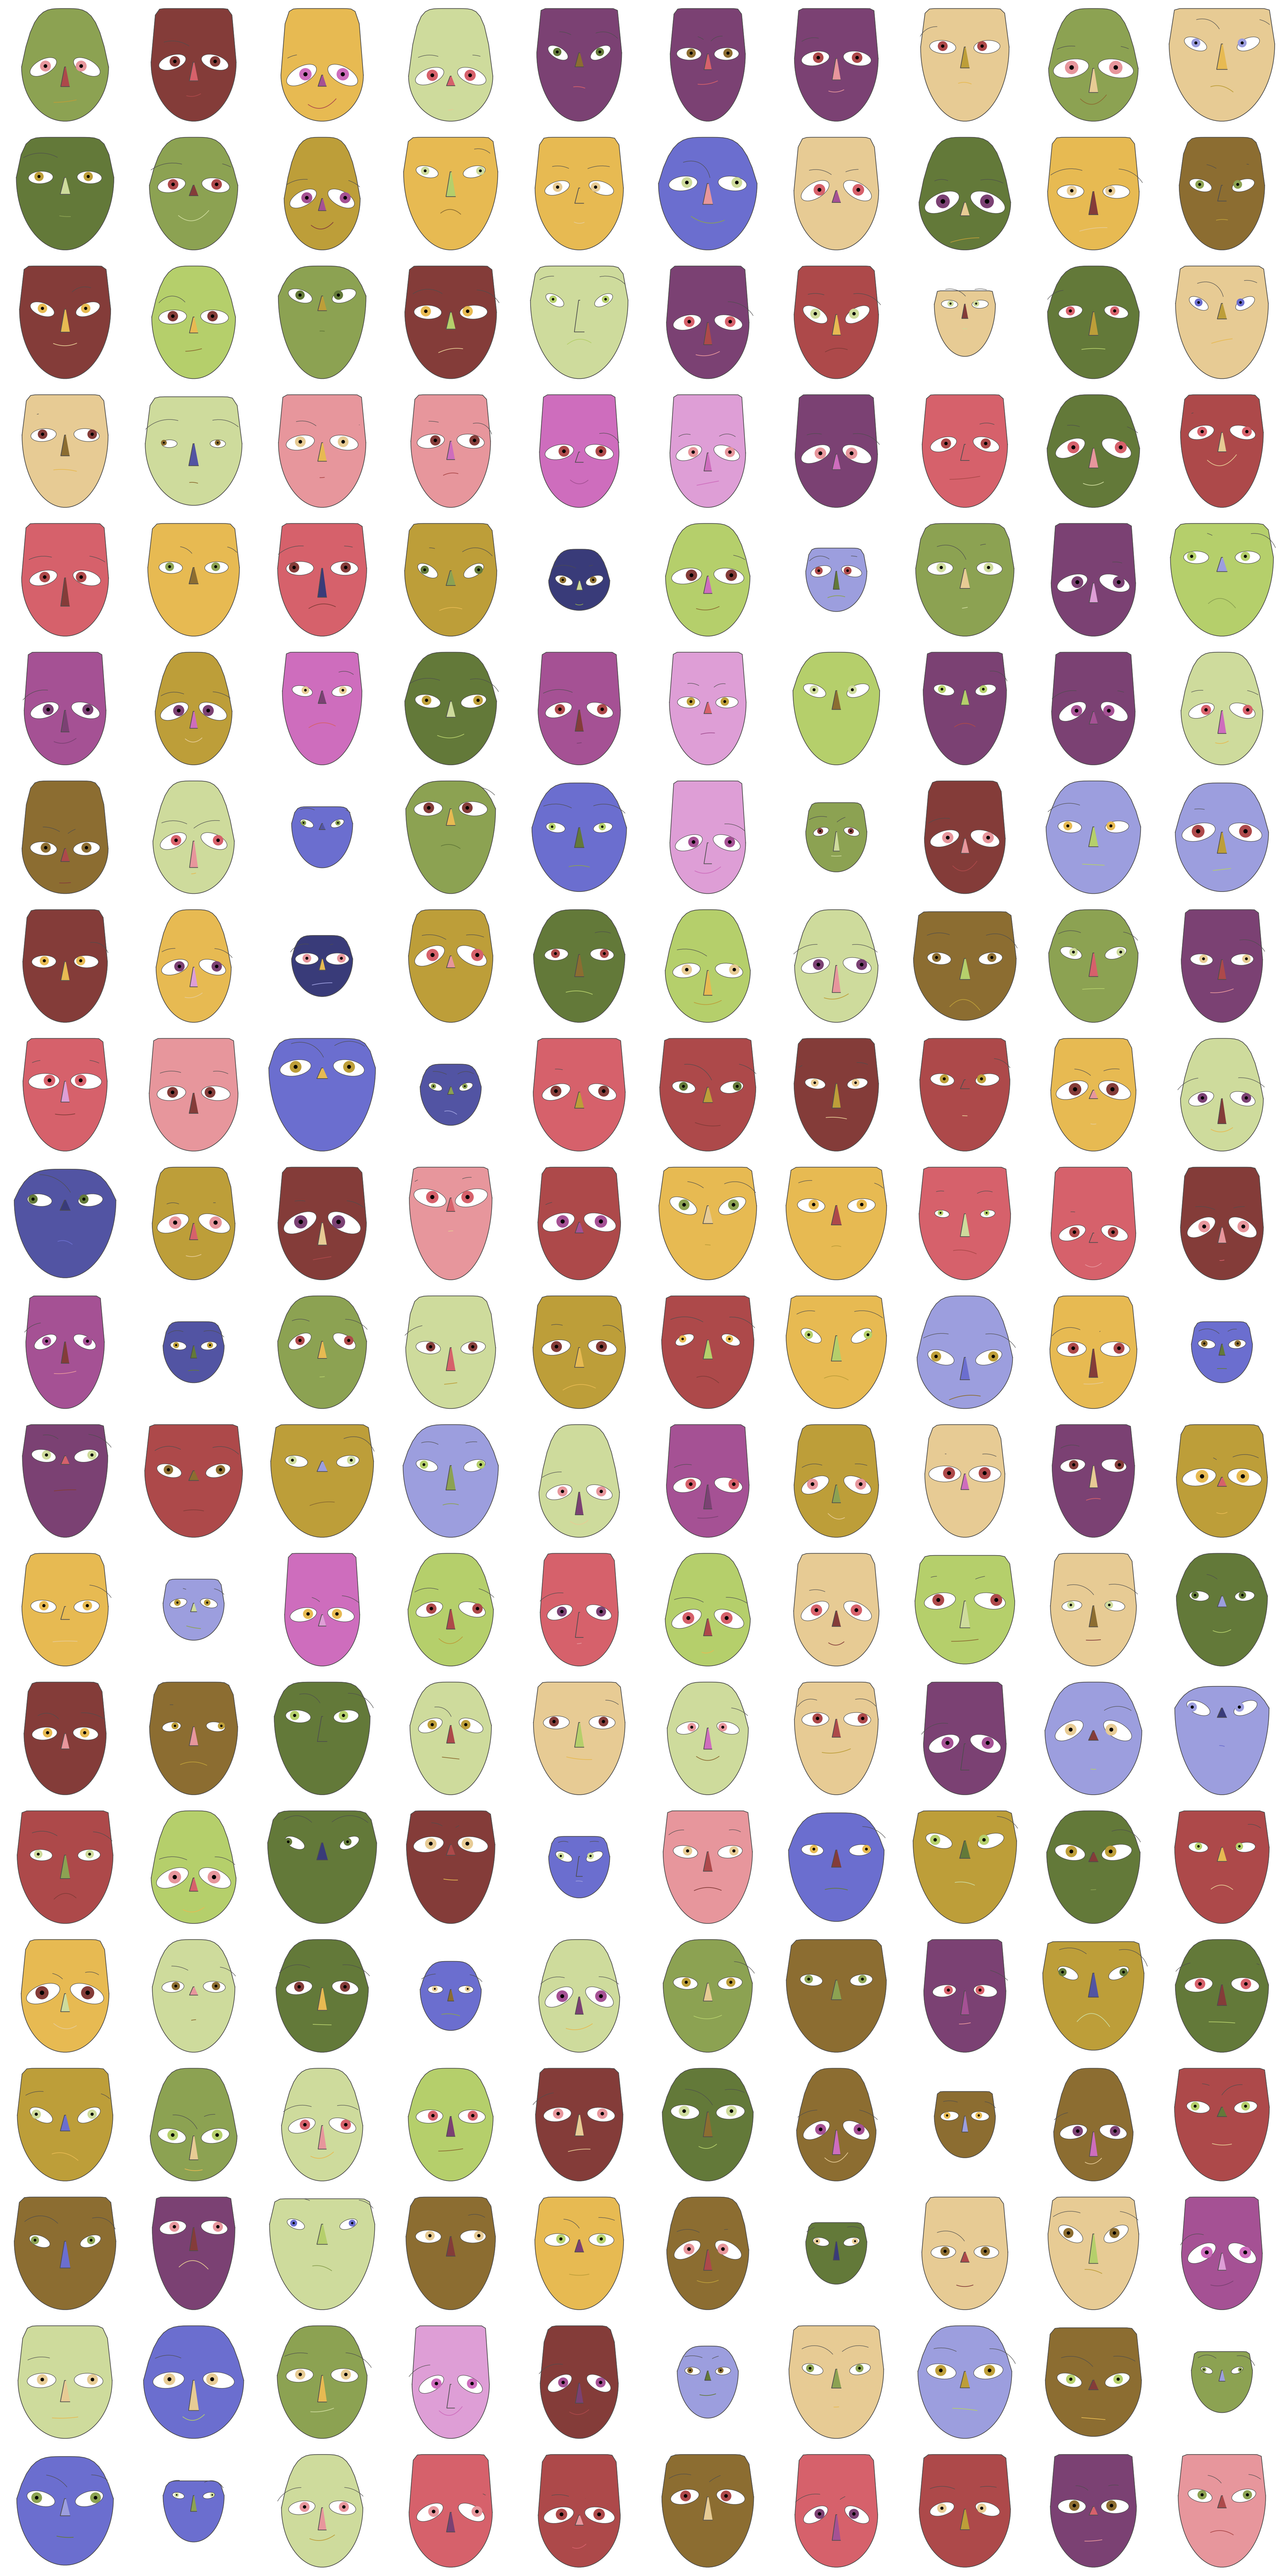

In [11]:
fig = chernoff_face(data=df.iloc[:,:200].transpose(),
                    n_columns=10,
                    long_face=True,
                    color_mapper=matplotlib.cm.tab20b,
                    figsize=(40, 80), dpi=100)
fig.tight_layout()
matplotlib.pyplot.show()

:|

# Clustering

## RNAseq
Separates samples in groups of equal variance, minimizing inertia (within-cluster sum of squares). 
$$\sum_{i=0}^n min(||x_i - \mu_j||^2)$$
$\mu_j$ : cluster mean (centroid)

Recomputes centroids coordinates until it stops moving.
K-means can lead to local min, k-means++ initializes centroids tobe distant from each other -> better than random initialization.

Tests with k-means and k-means++ for 10 and 100 clusters.

### Tests

In [139]:
kmeans10 = KMeans(n_clusters=10, init = 'random', n_init = 30, verbose = 0).fit(X)

In [143]:
print("Inertia :",kmeans10.inertia_)
print("N_iter :", kmeans10.n_iter_)

Inertia : 1307656.452864893
N_iter : 112


In [144]:
kmeans100 = KMeans(n_clusters=100, init = 'random', n_init = 30, verbose = 0).fit(X)
print("Inertia :",kmeans100.inertia_)
print("N_iter :", kmeans100.n_iter_)

Inertia : 975381.9989132134
N_iter : 48


In [145]:
kmeanspp10 = KMeans(n_clusters=10, init = 'k-means++', n_init = 30, verbose = 0).fit(X)
print("Inertia :",kmeanspp10.inertia_)
print("N_iter :", kmeanspp10.n_iter_)

Inertia : 1307639.3522536464
N_iter : 54


In [147]:
kmeanspp100 = KMeans(n_clusters=100, init = 'k-means++', n_init = 30, verbose = 0).fit(X)
print("Inertia :",kmeanspp100.inertia_)
print("N_iter :", kmeanspp100.n_iter_)

Inertia : 967889.1284580982
N_iter : 95


In [201]:
kmeansTest = [kmeans10,kmeans100,kmeanspp10,kmeanspp100]
kmeansNames = ["rand10","rand100","++10","++100"]
kmeansTimes = [10,100,10,100]
kmeansDf = [pd.DataFrame(kmeansTest[i].cluster_centers_) for i in range(len(kmeansTest))]
[kmeansDf[i].insert(0, 'method', [kmeansNames[i]]*kmeansTimes[i]) for i in range(len(kmeansTest))]

kmeansCenter = pd.concat(kmeansDf)

In [202]:
kmeansCenter.shape

(220, 201)

([], [])

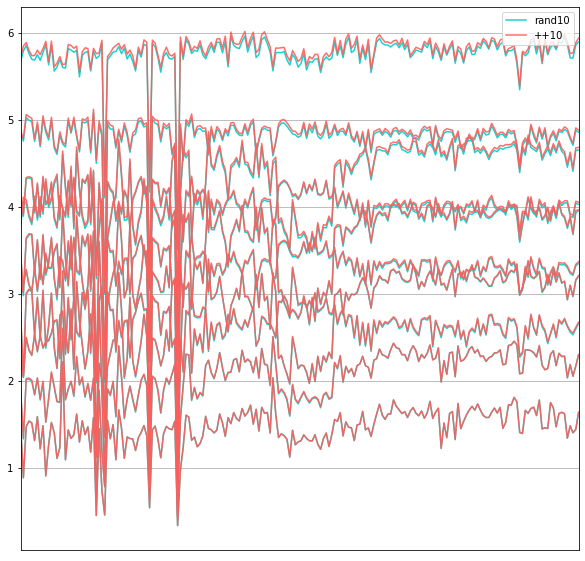

In [284]:
where = pd.DataFrame(kmeansCenter['method']!="++100")
where = where * pd.DataFrame(kmeansCenter['method']!="rand100")
pd.plotting.parallel_coordinates(kmeansCenter.loc[where.values,],
                                 class_column='method', alpha=0.9, axvlines=False, 
                                 color = ('#00CECB', '#FF5E5B'))
plt.xticks([])

Cluster centroids are very similar with the two methods for 10 clusters.

([], [])

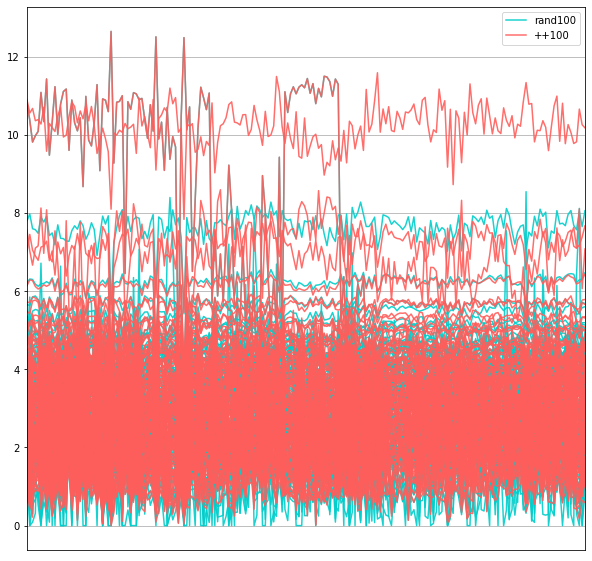

In [282]:
where = pd.DataFrame(kmeansCenter['method']=="++100")
where = where + pd.DataFrame(kmeansCenter['method']=="rand100")
pd.plotting.parallel_coordinates(kmeansCenter.loc[where.values,],
                                 class_column='method', alpha=0.9, axvlines=False, 
                                 color = ('#00CECB', '#FF5E5B'))
plt.xticks([])

Looks like the two methods find different clusters. Not a good visualisation for a lot of clusters.

### SSE measure
How does the SSE (inertia) of the clustering evolve for a varying number of clusters ?

In [ ]:
def SSE_nclust(X, k_list = np.unique(np.logspace(0,3,20, dtype=int)+1)):
    # Get SSE when varying the number of clusters
    sse_list = []
    k_list = np.unique(np.logspace(0,3,20, dtype=int)+1)
    for i in k_list:
        km_i_clusters=KMeans(n_clusters=i)
        km_i_clusters.fit(X)
        sse_list = sse_list + [km_i_clusters.inertia_]
    #print(sse_list)
    fig = plt.figure(figsize=(15, 6))
    plt.plot(k_list,sse_list,'bo--')
    plt.grid()
    plt.xlabel("nb of clusters",fontsize=14)
    plt.ylabel("SSE",fontsize=14)
    plt.show
    return sse_list

Text(0, 0.5, 'SSE')

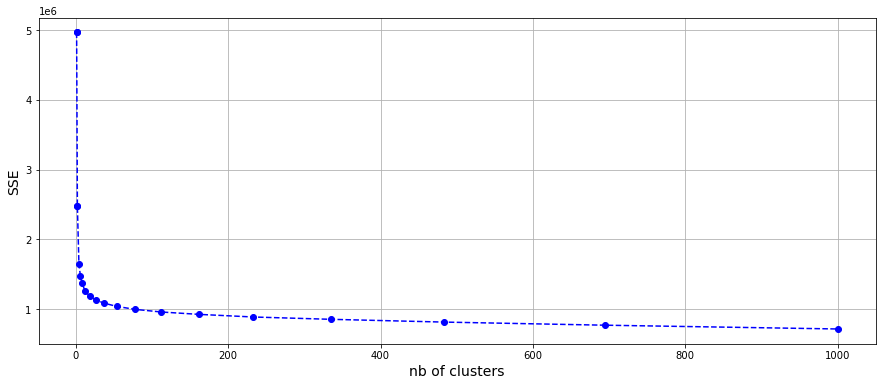

In [301]:
rna_sse = SSE_nclust(X, k_list = np.unique(np.logspace(0,3,20, dtype=int)+1))

An appropriate number of clusters for this data set would be between 100-200 clusters : with less clusters, the SSE quickly rises, and more clusters won't have a big impact on the SSE.

### Stability of k-means
Silhouette coefficient : a higher Silhouette Coefficient score relates to a model with better defined clusters.
$$s = \frac{b-a}{max(a,b)}$$
- $a$ : mean distance between a sample and all other points of the cluster
- $b$ : mean distance between a sample and all other points of the nearest cluster

`n_init` is set to $1$ so the k-means algorithm is only ran one time with the first random initial centroids. If over the $100$ k-means run the SSE and silhouette coefficient stays the same, it means that the same clusters have been found each time and that k-means output is stable.


In [302]:
avg_silhouette_coef = []
sse_list = []
k = 100 # number of clusters
n_init=1
for i in range(100):
    km = KMeans(n_clusters=k,init='random',n_init=n_init) # create a KMeans object
    km.fit(X)
    labels = km.predict(X)
    sse_list.append(np.sqrt(km.inertia_))
    avg_silhouette_coef.append(silhouette_score(X, labels,metric='euclidean'))

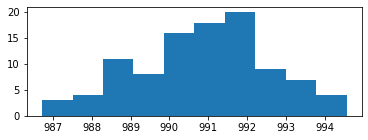

In [313]:
fig = plt.figure(figsize=(6, 2))
#_ = plt.boxplot(sse_list)
_ = plt.hist(sse_list)

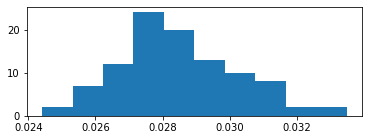

In [314]:
fig = plt.figure(figsize=(6, 2))
#_ = plt.boxplot(avg_silhouette_coef)
_ = plt.hist(avg_silhouette_coef)

#### Stability for a large number of inner run

In [317]:
avg_silhouette_coef = []
sse_list = []
k = 100 # number of clusters
n_init=20
for i in range(100):
    km = KMeans(n_clusters=k,init='random',n_init=n_init) # create a KMeans object
    km.fit(X)
    labels = km.predict(X)
    sse_list.append(np.sqrt(km.inertia_))
    avg_silhouette_coef.append(silhouette_score(X, labels,metric='euclidean'))
    print("\r",i+1,"%",end="\r")

Text(0.5, 1.0, 'Silhouette coef')

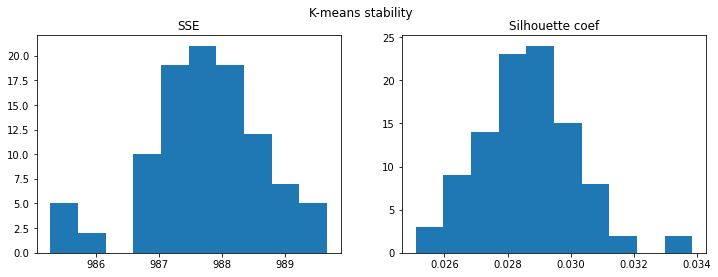

In [325]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
fig.suptitle('K-means stability')
ax1.hist(sse_list)
ax1.set_title('SSE')
ax2.hist(avg_silhouette_coef)
ax2.set_title('Silhouette coef')

For more inner runs, the SSE can decrease a bit.

#### Stability for different numbers of clusters
Evaluated through silhouette coefficient and SSE standard deviation.

In [6]:
def compute_silhouette_sse(df,k,iterations=100):
    avg_silhouette_coef = []
    sse_list = []
    for i in range(iterations):
        #km = KMeans(n_clusters=k,init='random',n_init=1) # create a KMeans object
        km = KMeans(n_clusters=k) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        avg_silhouette_coef.append(silhouette_score(df, labels,metric='euclidean'))
        sse_list.append(km.inertia_)
    return(np.asarray(avg_silhouette_coef),np.asarray(sse_list))

In [8]:
compute_silhouette_sse(X,2,iterations=1)

(array([0.39095426]), array([2471778.50675745]))

In [9]:
stabSil = []
stabSSE = []
k_list = np.unique(np.logspace(0,3,40, dtype=int)+1)
for i in range(len(k_list)):
    sil,sse = compute_silhouette_sse(X,k_list[i],iterations=10)
    stabSil.append(sil.std())
    stabSSE.append(sse.std())
    print("\r",round((i+1)/len(k_list)*100),"%",end="\r")

Text(0, 0.5, 'Instability: std(SSE)')

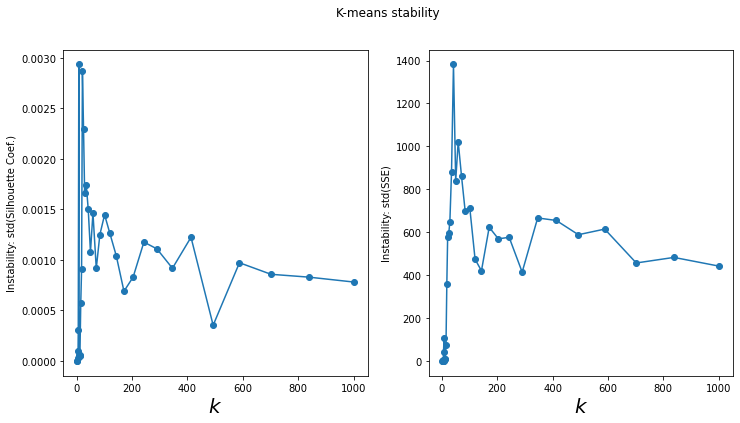

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
fig.suptitle('K-means stability')

ax1.plot(k_list,stabSil,"o-")
ax1.set_xlabel("$k$",fontsize=20)
ax1.set_ylabel("Instability: std(Silhouette Coef.)")

ax2.plot(k_list,stabSSE,"o-")
ax2.set_xlabel("$k$",fontsize=20)
ax2.set_ylabel("Instability: std(SSE)")

K-means output seems to stabilise itself for about 200 clusters. This result is consistent with the observation of SSE for different numbers of clusters.

### FOM

In [ ]:
import utilsClust
from importlib import reload
import seaborn as sns
import sklearn

In [358]:
reload(utilsClust)

<module 'utilsClust' from '/home/ldap/ipellet/Documents/Clustering/utilsClust.py'>

In [317]:
df = pd.read_csv("../data/RNAseqData.csv", index_col = 0)
X = df.transpose()

In [318]:
k_list = np.unique(np.linspace(2,300,100, dtype=int))
FOM,aFOM = utilsClust.multipleFOM(X, sklearn.cluster.KMeans, sk=True, rep=10, n_clusters=k_list)

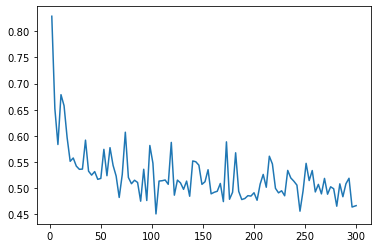

In [319]:
plt.plot(k_list, aFOM)

In [320]:
FOMdf = pd.DataFrame(FOM)
aFOMdf = pd.DataFrame(aFOM)
FOMdf.to_csv('Kmeans_rna_FOM.csv')
aFOMdf.to_csv('Kmeans_rna_aFOM.csv')

A relatively stable score seems to be obtain from about `n_clusters = 100`

### Silhouette

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 100 The average silhouette_score is : 0.02002031386071219
For n_clusters = 101 The average silhouette_score is : 0.019820742778389574
For n_clusters = 102 The average silhouette_score is : 0.02060052677353477
For n_clusters = 103 The average silhouette_score is : 0.020241781540253582
For n_clusters = 104 The average silhouette_score is : 0.021245572917997987
For n_clusters = 105 The average silhouette_score is : 0.020554627236604308
For n_clusters = 106 The average silhouette_score is : 0.020566419798333364
For n_clusters = 107 The average silhouette_score is : 0.021012078762782466
For n_clusters = 108 The average silhouette_score is : 0.02086491778970221
For n_clusters = 109 The average silhouette_score is : 0.020852217263719525
For n_clusters = 110 The average silhouette_score is : 0.0208257530202908
For n_clusters = 111 The average silhouette_score is : 0.015516944130180265
For n_clusters = 112 The average silhouette_score is : 0.019199356018578567
For n_clusters = 

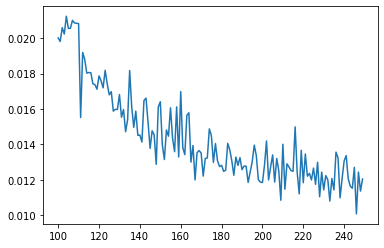

In [344]:
range_n_clusters = [i for i in range(100,250)]
avgSil = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    avgSil.append(silhouette_avg)
    
    if False:
         # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

#plt.show()
plt.plot(range_n_clusters, avgSil)

In [345]:
import pickle

In [346]:
f = open("Kmeans_rna_sil.txt", "wb")
pickle.dump([range_n_clusters, avgSil], f)
f.close()

### MM

In [21]:
KMeans_rna = KMeans(n_clusters=200,init='k-means++', n_init=10).fit(X)

In [22]:
KMeans_rna_mm = utilsClust.lab2mat(KMeans_rna.labels_, X.index)

In [23]:
KMeans_rna_mm.to_csv('./ModuleMatrix/KMeans_rna_200.csv', index=True, header=False)

# Gene2vec data

In [14]:
X = pd.read_csv("../data/gene2vec_dim_200_iter_9.csv", index_col=0)

### MM

In [13]:
import ICA

In [15]:
KMeans_g2v = KMeans(n_clusters=200,init='k-means++', n_init=10).fit(X)

In [16]:
KMeans_g2v_mm = utilsClust.lab2mat(KMeans_g2v.labels_, X.index)

In [18]:
KMeans_g2v_mm.to_csv('./ModuleMatrix/KMeans_g2v_200.csv', index=True, header=False)

### Params tuning

Text(0, 0.5, 'SSE')

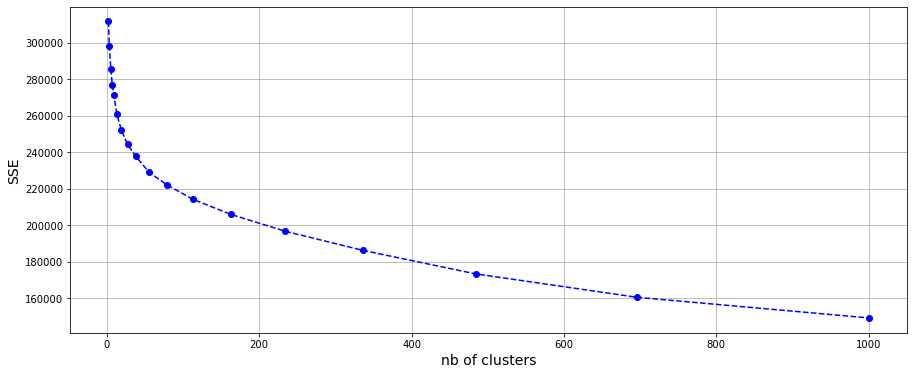

In [6]:
rna_sse = SSE_nclust(X, k_list = np.unique(np.logspace(0,3,20, dtype=int)+1))

In [7]:
stabSil = []
stabSSE = []
k_list = np.unique(np.logspace(0,2.8,100, dtype=int)+1)
for i in range(len(k_list)):
    sil,sse = compute_silhouette_sse(X,k_list[i],iterations=10)
    stabSil.append(sil.std())
    stabSSE.append(sse.std())
    print("\r",round((i+1)/len(k_list)*100),"%",end="\r")

Text(0, 0.5, 'Instability: std(SSE)')

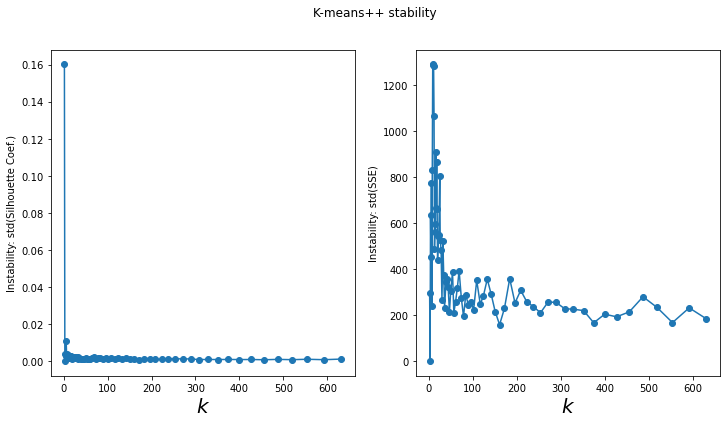

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
fig.suptitle('K-means++ stability')

ax1.plot(k_list,stabSil,"o-")
ax1.set_xlabel("$k$",fontsize=20)
ax1.set_ylabel("Instability: std(Silhouette Coef.)")

ax2.plot(k_list,stabSSE,"o-")
ax2.set_xlabel("$k$",fontsize=20)
ax2.set_ylabel("Instability: std(SSE)")

Rather stable from 200-300 clusters

In [17]:
k_list2 = np.unique(np.linspace(300,500,10, dtype=int))
#k_list

In [ ]:
import sklearn

In [20]:
g2v_FOM2, g2v_aFOM2, g2v_kw2 = utilsClust.multipleFOM(X, sklearn.cluster.KMeans, sk=True, rep=10, n_clusters=k_list2)

In [33]:
k_list = np.concatenate((k_list, k_list2))
g2v_aFOM = np.concatenate((g2v_aFOM, g2v_aFOM2))

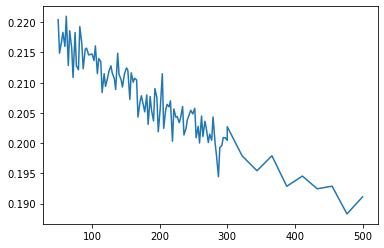

In [40]:
plt.plot(k_list, g2v_aFOM)

In [41]:
import pickle
file1 = open("Kmeans_g2v_ktest_50.500.txt", "wb") 
pickle.dump([k_list, g2v_aFOM], file1)
file1.close()

No stabilisation of FOM... Keeping `k = 200`.